In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

skewness = [0.5, 0.75, 0.9, 0.99]
n_points = [10**3, 10**4, 10**5]

def my_scores(model, X, y):
    y_hat =  model.predict(X)
    y_prob = model.predict_proba(X)[:,1]

    rcs = roc_auc_score(y, y_prob)
    precision, recall, _ = precision_recall_curve(y, y_prob)
    prcs = auc(recall, precision)
    cm = confusion_matrix(y, y_hat)
    f1 = f1_score(y, y_hat)

    return {'ROC-AUC': rcs, 'PRC-AUC': prcs, 'F1': f1, 'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}

def scores(skewness, n_points):
    fig, ax = plt.subplots(ncols=4, nrows= len(n_points), figsize=(20, 5*len(n_points)))

    df_temp = pd.DataFrame()

    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=36851234)

    for i, n in enumerate(n_points):
        for j, s in enumerate(skewness):
            X, y = make_classification(n_samples=n, n_features=2, n_redundant=0,
            	n_clusters_per_class=2, weights=[s], flip_y=0, random_state=7)
            
            sns.scatterplot(x=X[:,1], y=X[:,0], hue=y, ax=ax[i,j])
            ax[i,j].set_title('Point: {}, skewness: {}'.format(n,s))

            model = XGBClassifier()
            scores = (cross_validate(model, X, y, cv=rskf, scoring=my_scores, n_jobs=-1))
            
            df_temp_2 = pd.DataFrame()
            for key in ['ROC-AUC', 'PRC-AUC', 'F1', 'tn', 'fp', 'fn', 'tp']:
                df_temp_2[key] = scores['test_'+key]
            df_temp_2.loc[:, ['points', 'skewness']] = n, s
            if not df_temp.empty:
                df_temp = pd.concat([df_temp, df_temp_2], ignore_index=True)
            else:
                df_temp= df_temp_2
    
    plt.tight_layout()
    plt.show()

    df_temp['precision'] = df_temp['tp']/(df_temp['tp'] + df_temp['fp'])
    df_temp['recall'] = df_temp['tp']/(df_temp['tp'] + df_temp['fn'])
    df_temp['fnr'] = df_temp['tn']/(df_temp['tn'] + df_temp['fp'])
    
    fig, ax = plt.subplots(nrows=len(n_points), ncols=4, figsize=(20,15))
    for j, n in enumerate(n_points):
        sns.barplot(
            data= pd.melt(df_temp[['skewness', 'precision', 'recall', 'fnr']][df_temp['points'] == n], id_vars='skewness'), 
            x='skewness', y='value', hue='variable', errorbar='sd',
            ax=ax[j,0])
        ax[j,0].set_title('Precision, Recall (TPR) and FNR for {:,} points'.format(n))

        for i, key in enumerate(['ROC-AUC', 'PRC-AUC', 'F1'], 1):
            sns.barplot(
                data=df_temp[df_temp['points'] == n], x='skewness',
                y=key, errorbar='sd', ax=ax[j,i])
            ax[j,i].set_ylim(df_temp[df_temp['points'] == n][key].min(), 1.0)
            ax[j,i].set_title("{} for {:,} points".format(key, n))
    plt.tight_layout()
    plt.show()

    return df_temp

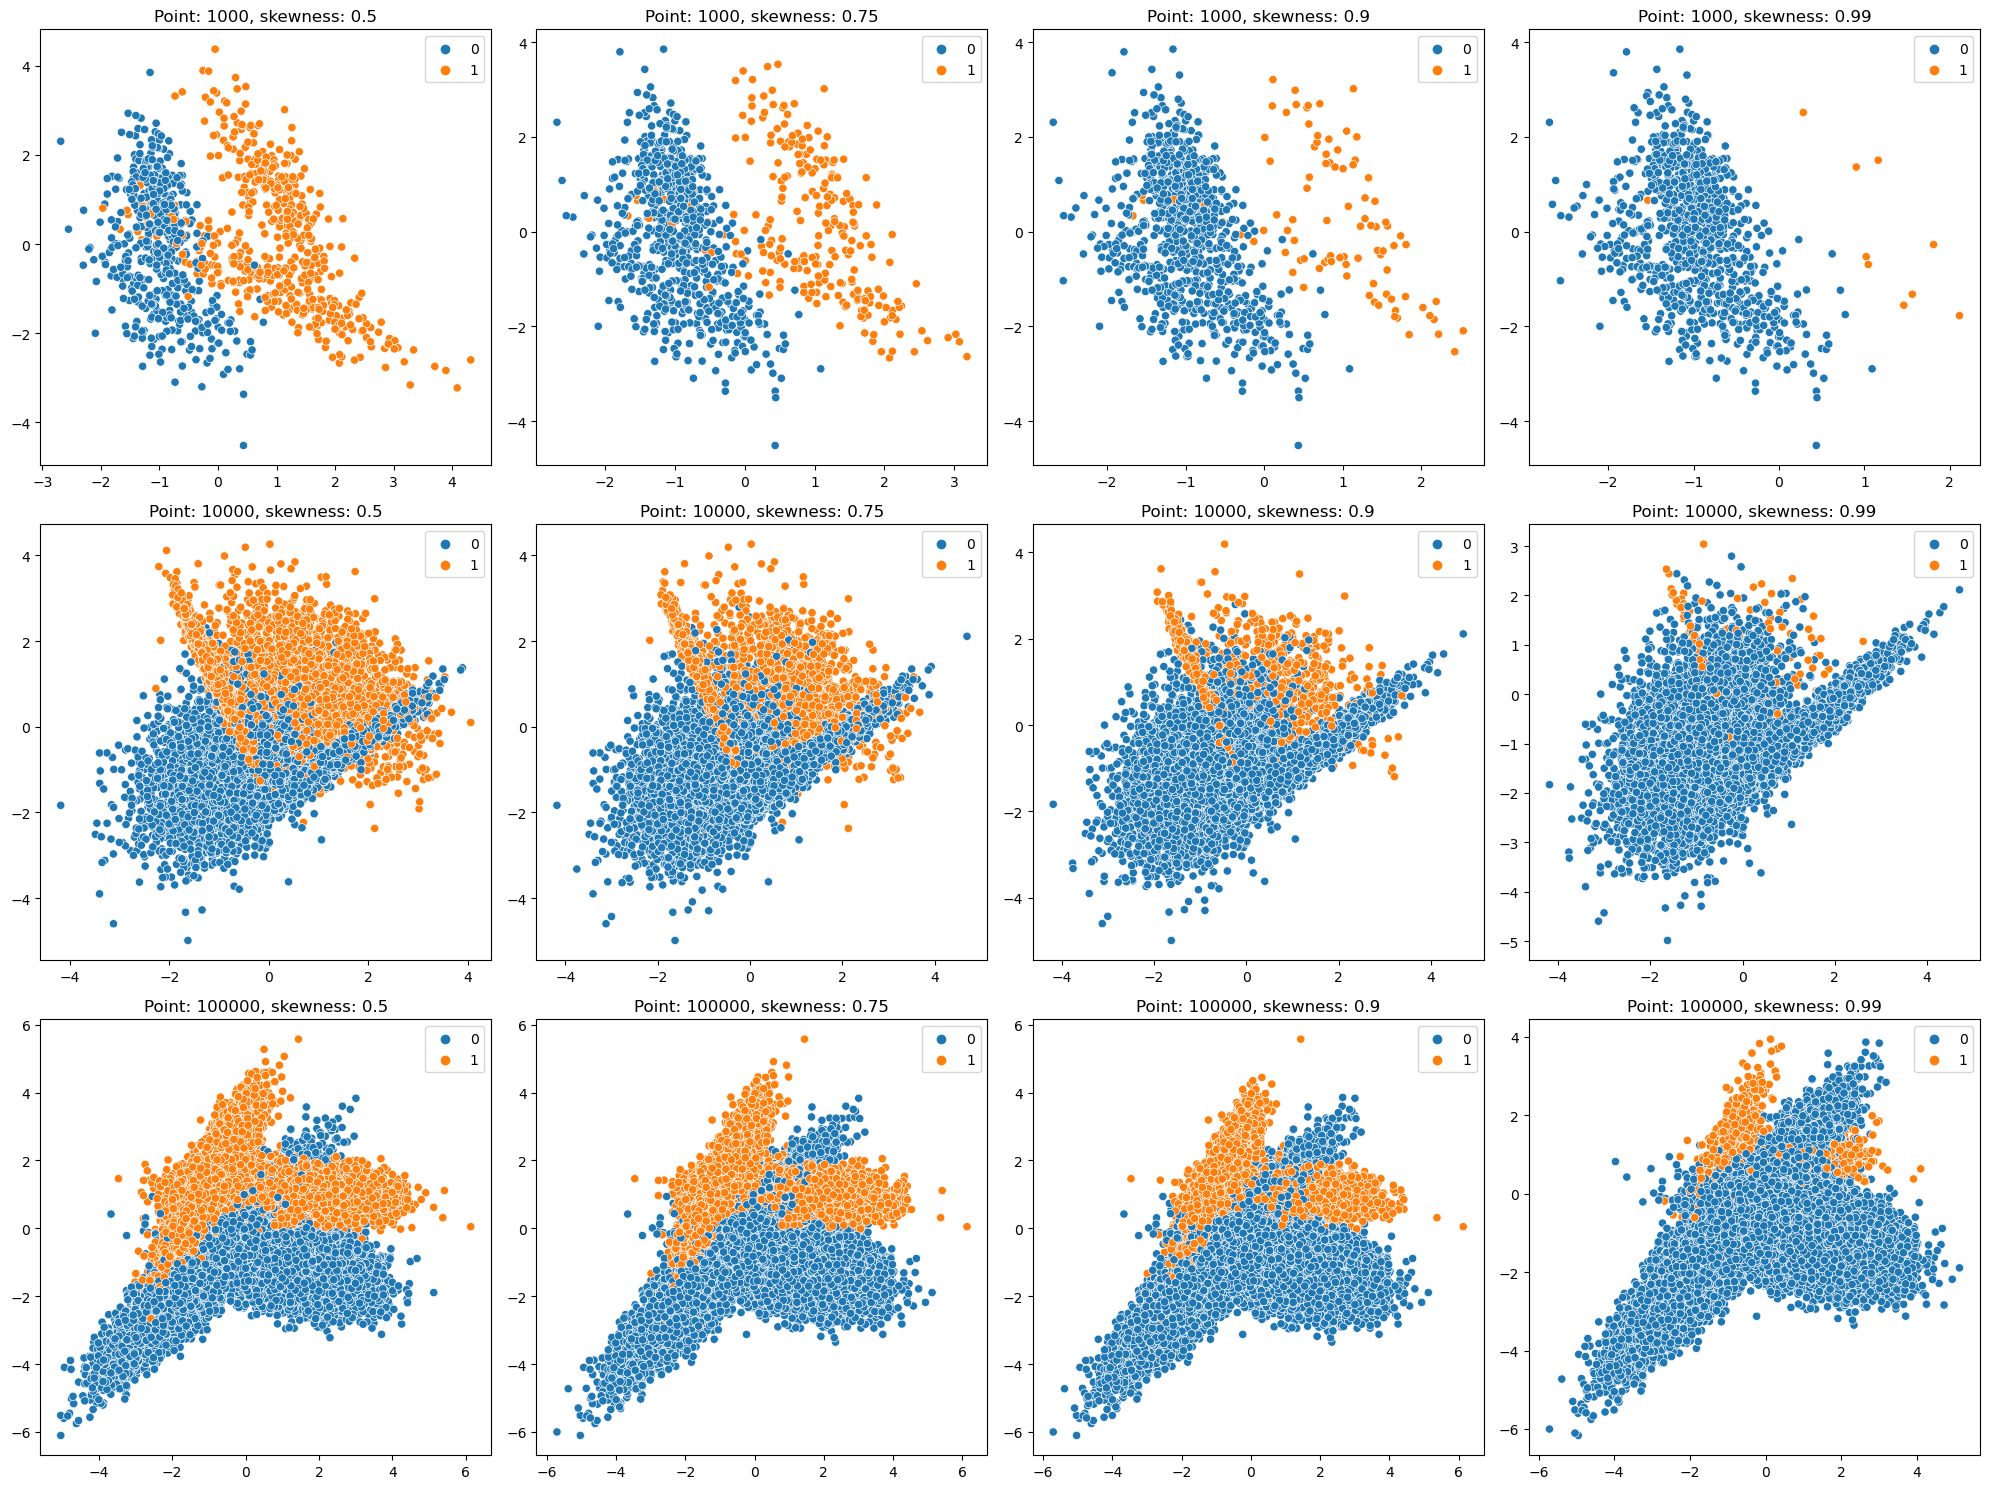

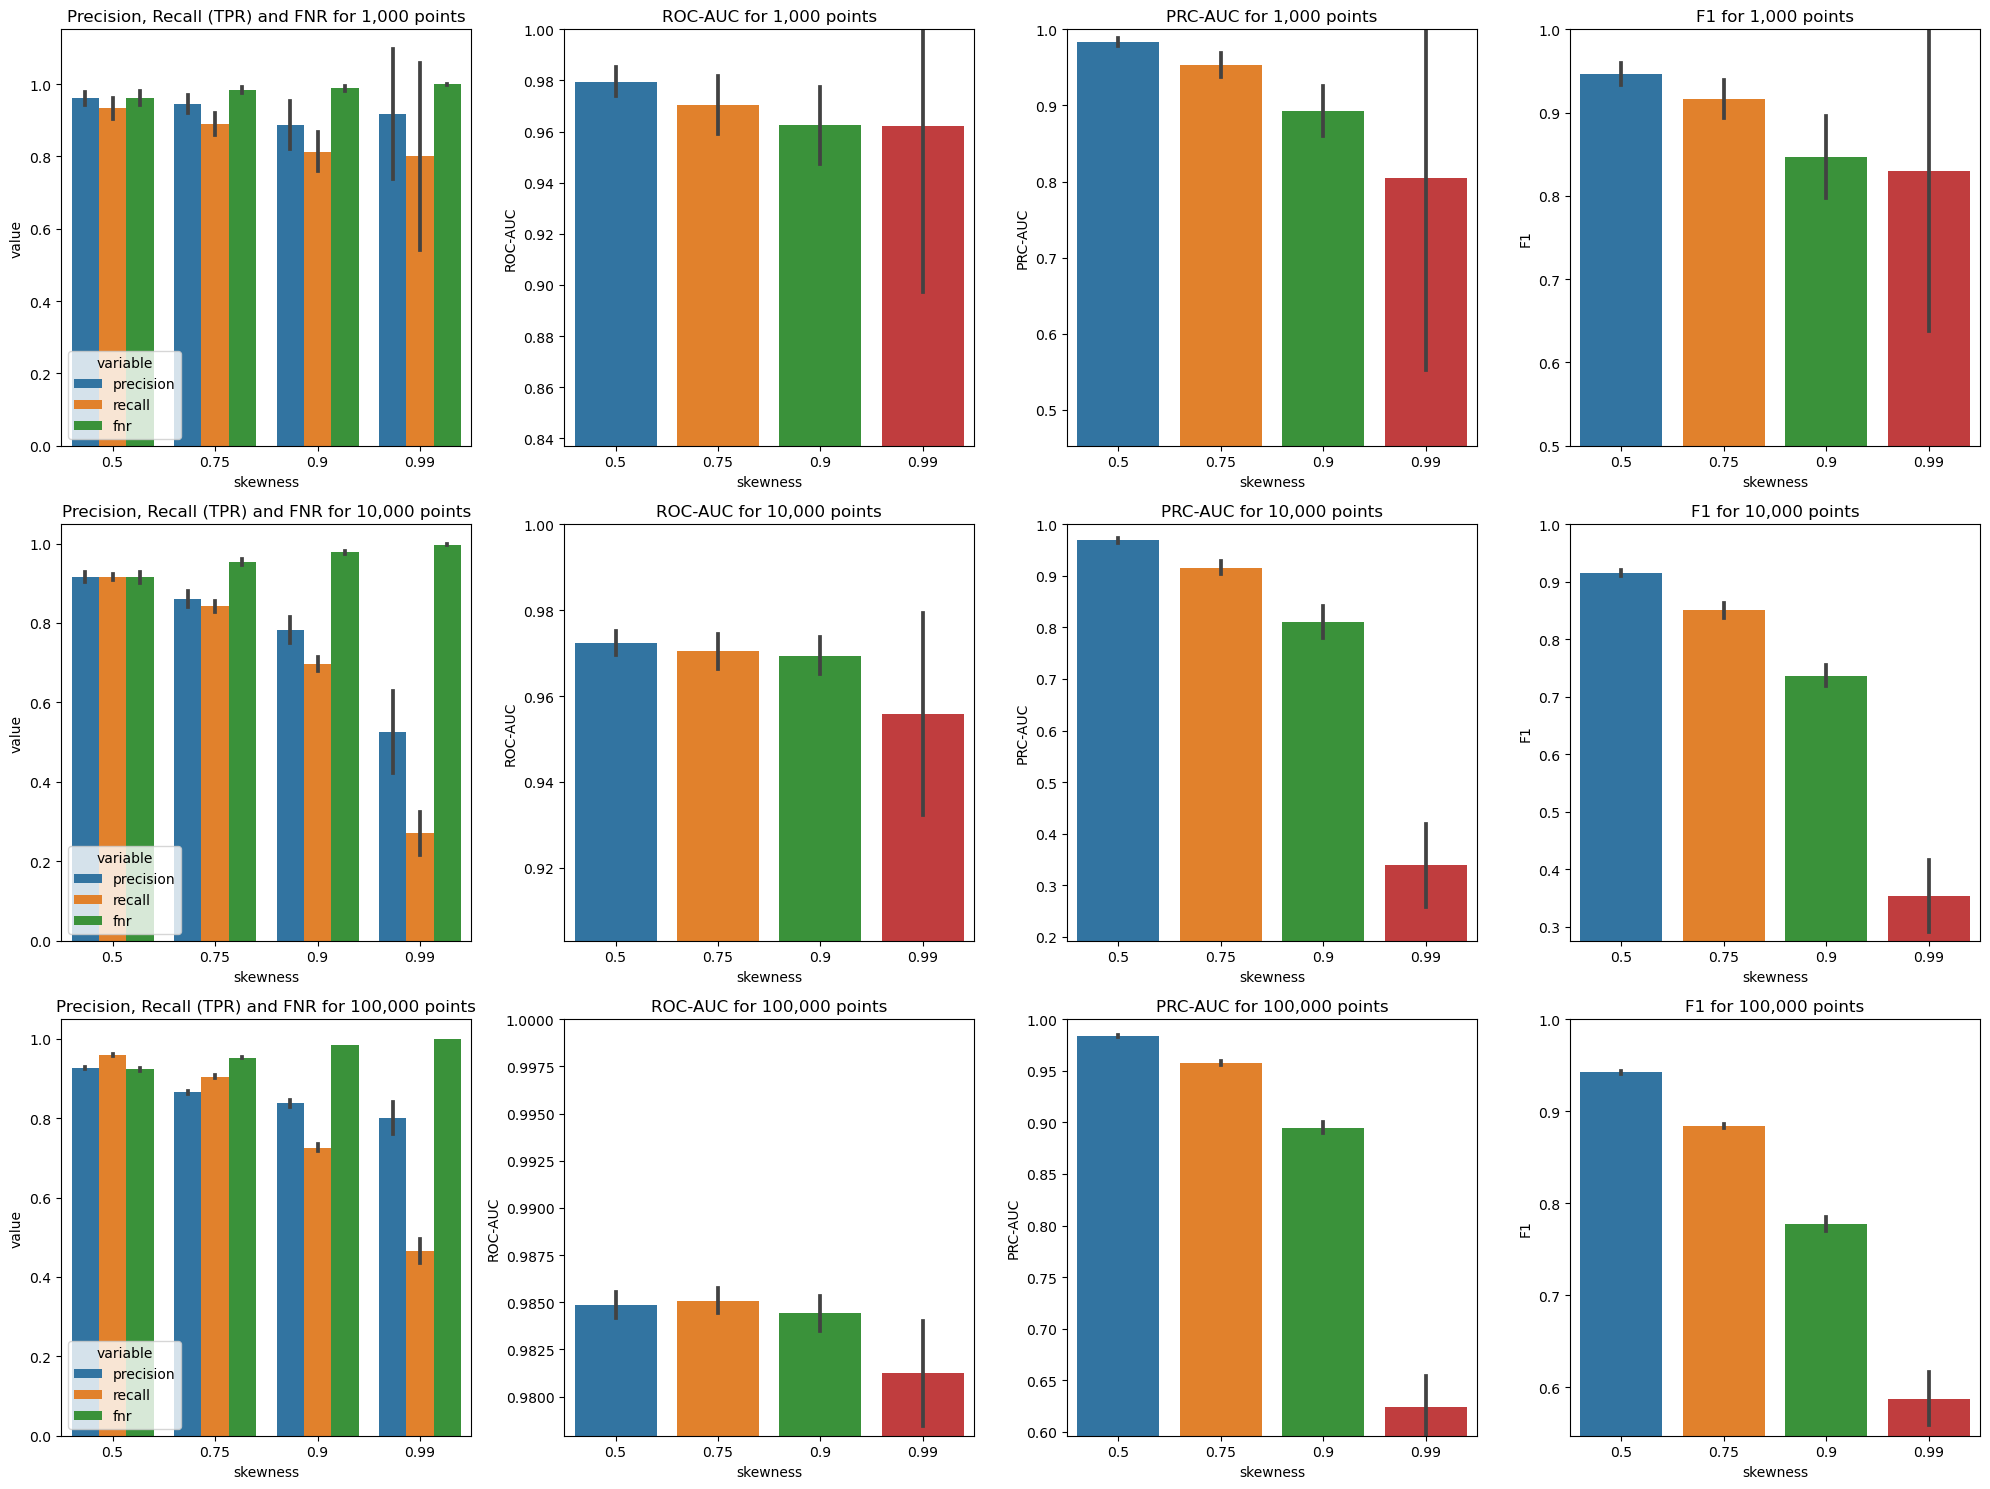

In [2]:
df_temp = scores(skewness, n_points)